<a href="https://colab.research.google.com/github/sirakik/japan_graph/blob/master/japan_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#モジュール

In [97]:
pip install dgl \
pip install networkx

In [98]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)

#日本グラフ作成

In [99]:
# 都道府県名
todofuken = {0:'Hokkaido', 1:'Aomori', 2:'Iwate', 3:'Miyagi', 4:'Akita', 5:'Yamagata', 6:'Fukushima', 7:'Ibaraki', 8:'Tochigi', 9:'Gumma', 10:'Saitama', 11:'Chiba', 12:'Tokyo', 13:'Kanagawa', 14:'Niigata', 15:'Toyama', 16:'Ishikawa', 17:'Fukui', 18:'Yamanashi', 19:'Nagano', 20:'Gifu', 21:'Shizuoka', 22:'Aichi', 23:'Mie', 24:'Shiga', 25:'Kyoto', 26:'Osaka', 27:'Hyogo', 28:'Nara', 29:'Wakayama', 30:'Tottori', 31:'Shimane', 32:'Okayama', 33:'Hiroshima', 34:'Yamaguchi', 35:'Tokushima', 36:'Kagawa', 37:'Ehime', 38:'Kochi', 39:'Fukuoka', 40:'Saga', 41:'Nagasaki', 42:'Kumamoto', 43:'Oita', 44:'Miyazaki', 45:'Kagoshima', 46:'Okinawa'}
# 県庁所在地 緯度経度
todofukencho_xy = {0:(43.06417,141.34694), 1:(40.82444,140.74), 2:(39.70361,141.1525), 3:(38.26889,140.87194), 4:(39.71861,140.1025), 5:(38.24056,140.36333), 6:(37.75,140.46778), 7:(36.34139,140.44667), 8:(36.56583,139.88361), 9:(36.39111,139.06083), 10:(35.85694,139.64889), 11:(35.60472,140.12333), 12:(35.68944,139.69167), 13:(35.44778,139.6425), 14:(37.90222,139.02361), 15:(36.69528,137.21139), 16:(36.59444,136.62556), 17:(36.06528,136.22194), 18:(35.66389,138.56833), 19:(36.65139,138.18111), 20:(35.39111,136.72222), 21:(34.97694,138.38306), 22:(35.18028,136.90667), 23:(34.73028,136.50861), 24:(35.00444,135.86833), 25:(35.02139,135.75556), 26:(34.68639,135.52), 27:(34.69139,135.18306), 28:(34.68528,135.83278), 29:(34.22611,135.1675), 30:(35.50361,134.23833), 31:(35.47222,133.05056), 32:(34.66167,133.935), 33:(34.39639,132.45944), 34:(34.18583,131.47139), 35:(34.06583,134.55944), 36:(34.34028,134.04333), 37:(33.84167,132.76611), 38:(33.55972,133.53111), 39:(33.60639,130.41806), 40:(33.24944,130.29889), 41:(32.74472,129.87361), 42:(32.78972,130.74167), 43:(33.23806,131.6125), 44:(31.91111,131.42389), 45:(31.56028,130.55806), 46:(26.2125,127.68111)}

In [100]:
# 陸路で通れる場合はエッジあり(例：北海道と青森)
rikuro_edge = [(0, 1), (1, 2), (1, 4), (2, 4), (2, 7), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6), (5, 14), (6, 7), (6, 8), (6, 9), (6, 14), (7, 8), (7, 10), (7, 11), (8, 9), (8, 10), (9, 10), (9, 14), (9, 19), (10, 11), (10, 12), (10, 18), (10, 19), (11, 12), (11, 13), (12, 13), (12, 18), (13, 18), (13, 21), (14, 15), (14, 19), (15, 16), (15, 19), (15, 20), (16, 17), (16, 20), (17, 20), (17, 24), (17, 25), (18, 19), (18, 21), (19, 20), (19, 21), (19, 22), (20, 22), (20, 23), (20, 24), (21, 22), (22, 23), (23, 24), (23, 25), (23, 28), (23, 29), (24, 25), (25, 26), (25, 27), (25, 28), (26, 27), (26, 28), (26, 29), (27, 30), (27, 32), (27, 35), (28, 29), (30, 31), (30, 32), (30, 33), (31, 33), (31, 34), (32, 33), (32, 36), (33, 34), (33, 37), (34, 39), (35, 36), (35, 37), (35, 38), (36, 37), (37, 38), (39, 40), (39, 42), (39, 43), (40, 41), (42, 43), (42, 44), (42, 45), (43, 44), (44, 45)]

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


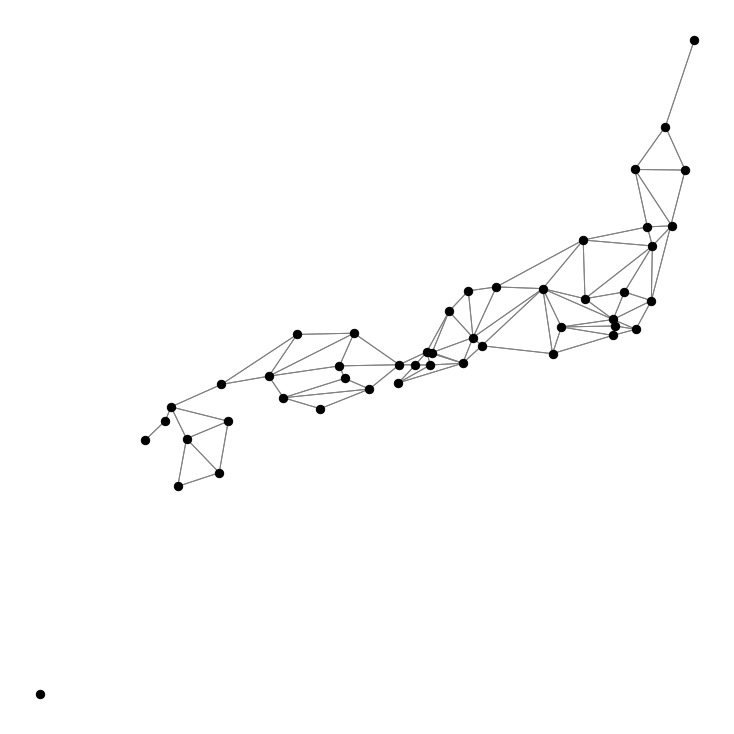

In [142]:
# 日本グラフ作成
g = dgl.DGLGraph()
g.add_nodes(len(todofuken))

# 陸路edgeを追加 
src, dst = tuple(zip(*rikuro_edge))
g.add_edges(src, dst)
g.add_edges(dst, src)

# ループを追加
roop_edge = [(i, i) for i in range(len(todofuken))]
src, dst = tuple(zip(*roop_edge))
g.add_edges(src, dst)

# 描画
nx_g = g.to_networkx()
pos_ = {n: (todofukencho_xy[n][1], todofukencho_xy[n][0]) for n in range(len(todofuken))}
nx.draw(nx_g, pos=pos_, arrows=False, node_size=70, with_labels=False, labels=todofuken, node_color=[0, 0, 0], edge_color=[0.5, 0.5, 0.5])
plt.show()

#データ

人口(総務省統計局:https://www.stat.go.jp/data/nihon/zuhyou/n200200200.xlsx)  
平成27年,国勢調査にもとづく

In [106]:
population = [5382000, 1308000, 1280000, 2334000, 1023000, 1124000, 1914000, 2917000, 1974000, 1973000, 7267000, 6223000, 13515000, 9126000, 2304000, 1066000, 1154000, 787000, 835000, 2099000, 2032000, 3700000, 7483000, 1816000, 1413000, 2610000, 8839000, 5535000, 1364000, 964000, 573000, 694000, 1922000, 2844000, 1405000, 756000, 976000, 1385000, 728000, 5102000, 833000, 1377000, 1786000, 1166000, 1104000, 1648000, 1434000]

人口密度(上記と同様)  
平成27年,国勢調査にもとづく  
[人/km^2]

In [107]:
population_density = [68.6, 135.6, 83.8, 320.5, 87.9, 120.5, 138.9, 478.4, 308.1, 310.1, 1913.4, 1206.5, 6168.7, 3777.7, 183.1, 251.0, 275.7, 187.7, 187.0, 154.8, 191.3, 475.8, 1446.7, 314.5, 351.7, 566.0, 4639.8, 658.8, 369.6, 203.9, 163.5, 103.5, 270.1, 335.4, 229.8, 182.3, 520.2, 244.1, 102.5, 1023.1, 341.2, 333.3, 241.1, 183.9, 142.7, 179.4, 628.4]

https://nlftp.mlit.go.jp/ksj/index.html

# 空港グラフ

In [133]:
# 0<旅客数<=100000 　を　few_pas_graph
few_pas_graph = [(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (0, 14), (0, 15), (0, 16), (0, 19), (0, 21), (0, 32), (0, 33), (0, 46), (1, 22), (1, 26), (2, 22), (2, 26), (2, 39), (3, 11), (3, 16), (3, 33), (3, 46), (4, 22), (4, 26), (5, 26), (6, 26), (7, 27), (7, 30), (7, 46), (11, 14), (11, 16), (11, 30), (11, 33), (11, 36), (11, 37), (11, 43), (11, 45), (12, 22), (12, 29), (14, 22), (14, 39), (14, 46), (16, 39), (16, 46), (19, 39), (21, 39), (21, 45), (21, 46), (22, 37), (22, 38), (22, 41), (22, 43), (22, 44), (26, 27), (26, 31), (26, 43), (27, 30), (27, 41), (27, 45), (31, 39), (32, 46), (33, 46), (35, 39), (36, 46), (37, 39), (37, 45), (37, 46), (38, 39), (39, 42), (39, 45), (40, 41), (41, 46), (42, 46), (44, 46)]
# 100000 <旅客数 を many_pas_graph
many_pas_graph = [(0, 3), (0, 11), (0, 12), (0, 22), (0, 26), (0, 27), (0, 39), (1, 12), (3, 22), (3, 26), (3, 39), (4, 12), (5, 12), (11, 22), (11, 26), (11, 39), (11, 46), (12, 15), (12, 16), (12, 26), (12, 27), (12, 30), (12, 31), (12, 32), (12, 33), (12, 34), (12, 35), (12, 36), (12, 37), (12, 38), (12, 39), (12, 40), (12, 41), (12, 42), (12, 43), (12, 44), (12, 45), (12, 46), (14, 26), (22, 39), (22, 42), (22, 45), (22, 46), (26, 37), (26, 38), (26, 39), (26, 41), (26, 42), (26, 44), (26, 45), (26, 46), (27, 46), (39, 40), (39, 44), (39, 46), (45, 46)]

In [134]:
#別でグラフ作った方がいいのかな?
# few pas graph
air_few_pas_g = dgl.DGLGraph()
air_few_pas_g.add_nodes(len(todofuken))

# few edgeを追加 
src, dst = tuple(zip(*few_pas_graph))
air_few_pas_g.add_edges(src, dst)
air_few_pas_g.add_edges(dst, src)

src, dst = tuple(zip(*roop_edge))
air_few_pas_g.add_edges(src, dst)


# many pas graph
air_many_pas_g = dgl.DGLGraph()
air_many_pas_g.add_nodes(len(todofuken))

# ループを追加
roop_edge = [(i, i) for i in range(len(todofuken))]
src, dst = tuple(zip(*roop_edge))
air_many_pas_g.add_edges(src, dst)

# few edgeを追加 
src, dst = tuple(zip(*few_pas_graph))
air_many_pas_g.add_edges(src, dst)
air_many_pas_g.add_edges(dst, src)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


(tensor([ 0,  1,  1,  2,  2,  3,  3,  3,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,
         8,  8,  9,  9,  9, 10, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15,
        15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 21, 22, 23,
        23, 23, 23, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 30, 30, 30, 31,
        31, 32, 32, 33, 33, 34, 35, 35, 35, 36, 37, 39, 39, 39, 40, 42, 42, 42,
        43, 44,  1,  2,  4,  4,  7,  4,  5,  6,  5,  6, 14,  7,  8,  9, 14,  8,
        10, 11,  9, 10, 10, 14, 19, 11, 12, 18, 19, 12, 13, 13, 18, 18, 21, 15,
        19, 16, 19, 20, 17, 20, 20, 24, 25, 19, 21, 20, 21, 22, 22, 23, 24, 22,
        23, 24, 25, 28, 29, 25, 26, 27, 28, 27, 28, 29, 30, 32, 35, 29, 31, 32,
        33, 33, 34, 33, 36, 34, 37, 39, 36, 37, 38, 37, 38, 40, 42, 43, 41, 43,
        44, 45, 44, 45,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39,

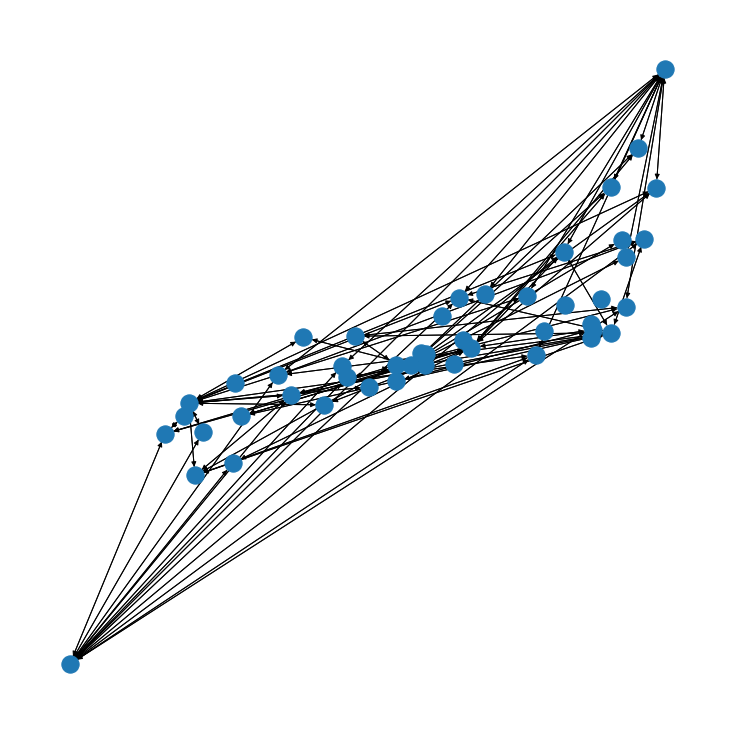

In [158]:
few_edge_list = air_few_pas_g.edges()
many_edge_list = air_many_pas_g.edges()

nx.draw(air_few_pas_g.to_networkx(), pos=pos_)
plt.show()